In [1]:
!pip install matplotlib_inline

In [ ]:
!pip install d2l

In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [2]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root = "../data", train = True, transform=trans, download = False)
mnist_test = torchvision.datasets.FashionMNIST(
    root = "../data", train = False, transform=trans, download=False)

In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [4]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [5]:
type(mnist_train[0][1])

int

In [6]:
def get_fashion_mnist_labels(labels):
  """Fashion-MNIST를 위한 텍스트라벨을 리턴"""
  text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
  return [text_labels[i] for i in labels]

In [7]:
# visualize example

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  """이미지 리스트 플롯그리기"""
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = d2l.plt.subplots(num_rows, num_cols, figsize = figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    if torch.is_tensor(img):
      # Tensor Image
      img = img.numpy()
      ax.imshow(img)
    else:
      # PIL Image
      ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles:
      ax.set_title(titles[i])
  return axes


In [ ]:
!pip install matplotlib==3.1.3

In [8]:
type(mnist_train)

torchvision.datasets.mnist.FashionMNIST

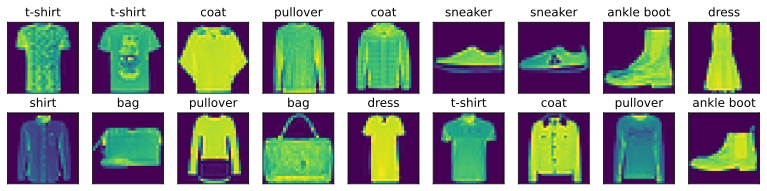

In [9]:
# training dataset 가져오기
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18, shuffle=True)))
show_images(X.reshape(18,28,28), 2, 9, titles = get_fashion_mnist_labels(y));

In [12]:
# Reading a Minibatch
batch_size = 256

def get_dataloader_workers():
  """Use 4 processes to read the data."""
  return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers = get_dataloader_workers())

In [13]:
# training data 읽는 시간 체크

timer = d2l.Timer()
for X, y in train_iter:
  continue
f'{timer.stop():.2f}.sec'

'44.42.sec'

In [14]:
# Putting All Things Together

def load_data_fashion_mnist(batch_size, resize=None):
  """Fashion-MNIST dataset 을 다운로드하고 memory로 로드"""
  trans = [transforms.ToTensor()]
  if resize:
    trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
  mnist_train = torchvision.datasets.FashionMNIST(
      root = "../data", train=True, transform=trans, download=True)
  mnist_test = torchvision.datasets.FashionMNIST(
      root="../data", train=False, transform=trans, download=True)
  return(data.DataLoader(mnist_train, batch_size, shuffle= True,
                         num_workers=get_dataloader_workers()),
         data.DataLoader(mnist_test, batch_size, shuffle= True,
                         num_workers=get_dataloader_workers()))


In [15]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
  print(X.shape, X.dtype, y.shape, y.dtype)
  break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


## 3.6 Implementation of Softmax Regression from Scratch

**코드 한 줄 한 줄이 어떤 이유로 쓰였는지 씹어보며 공부해보세요! 😀**

In [28]:
import torch
from IPython import display
from d2l import torch as d2l

In [29]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [30]:
# image flatten to vectors of length 784.
# 각 pixel 위치를 feature로 봄
# class 가 10개니까 아웃풋 dimension이 10
# Gaussian 노이즈로 W 초기값 설정
# 0으로 b 초기값 설정

num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.01, size = (num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad = True)

In [31]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0,5.0,6.0]])
X.sum(0, keepdim = True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [32]:
# softmax 함수를 구현해보세요.

def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1, keepdim=True)
  return X_exp / partition

In [34]:
X = torch.normal(0, 1, (2,5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0701, 0.1461, 0.2450, 0.0560, 0.4828],
         [0.4182, 0.0117, 0.0931, 0.3647, 0.1122]]),
 tensor([1., 1.]))

In [35]:
def net(X):
  return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [51]:
y = torch.tensor([0,2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0,1], y]

tensor([0.1000, 0.5000])

In [52]:
# cross-entropy loss function을 구현해보세요.

def cross_entropy(y_hat, y):
  return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [53]:
def accuracy(y_hat, y):
  """correct prediction 수를 계산"""
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = y_hat.argmax(axis = 1)
  cmp = y_hat.type(y.dtype) == y
  return float(cmp.type(y.dtype).sum())

In [54]:
accuracy(y_hat, y) / len(y)

0.5

In [55]:
def evaluate_accuracy(net, data_iter):
    """모델 정확도 계산"""
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)

    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [41]:
i = 0
for X, y in train_iter:
    i += 1
    print(X.shape, y.numel())
    print(accuracy(net(X), y))
    if i>3 : break

torch.Size([256, 1, 28, 28]) 256
42.0
torch.Size([256, 1, 28, 28]) 256
39.0
torch.Size([256, 1, 28, 28]) 256
51.0
torch.Size([256, 1, 28, 28]) 256
42.0


In [56]:
class Accumulator:
    """n 개 변수 합 축적"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [57]:
evaluate_accuracy(net, test_iter)

0.6507

In [58]:
def train_epoch(net, train_iter, loss, updater):
    """training loop"""
    # Set the model to training model
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, number of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [59]:
class Animator:
    """애니메이션으로 데이터 플롯팅"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


In [60]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    """모델 학습"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


In [61]:
lr = 0.1

def updater(batch_size):
  return d2l.sgd([W, b], lr, batch_size)

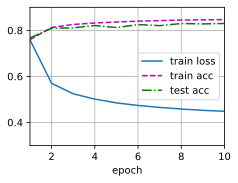

In [62]:
num_epochs = 10
train(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

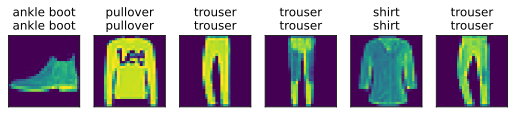

In [36]:
def predict(net, test_iter, n=6):
  for X, y in test_iter:
    break
  trues = d2l.get_fashion_mnist_labels(y)
  preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis = 1))
  titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
  d2l.show_images(
      X[0:n].reshape((n, 28, 28)), 1 , n, titles = titles[0:n])
predict(net, test_iter)

In [45]:
import torch
from torch import nn
from d2l import torch as d2l

In [43]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [46]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std = 0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [47]:
loss = nn.CrossEntropyLoss(reduction = 'none')

In [48]:
trainer = torch.optim.SGD(net.parameters(), lr = 0.1)

In [49]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

AttributeError: module 'd2l.torch' has no attribute 'train_ch3'

## 세션 때 배운 코드를 복습해봐요 😀

**강의자료 보지않고 빈 칸 채워보기!**

# Numpy

### data generation

In [73]:
import numpy as np

true_b = 1
true_w = 2

N = 100

np.random.seed(42)
x = np.random.rand(N,1)  # Uniform
epsilon = (0.1 * np.random.randn(N,1))  # standard normal dist  # noise
y = x*true_w + true_b + epsilon

### Train-Validation Split

In [74]:
# Shuffles the indices
idx = np.arange(N)
split_index = int(N * 0.8)

train_idx = idx[:split_index]
val_idx = idx[split_index:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

### Gradient Descent for Linear Regression

In [78]:
# 실행시간을 측정해주는 Decorator 입니다.

import time
def timer(func):
  def wrapper(*args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    computation_time = end_time - start_time
    print(f"Execution time of {func.__name__}: {computation_time} seconds")
    return result
  return wrapper

In [88]:
@timer
def train_model_numpy(lr = 0.1, epochs = 1000):
  # Initialize parameters
  b = np.random.randn(1)
  w = np.random.randn(1)

  for epoch in range(epochs):
    # Loss computation
    y_hat = b + w * x_train
    error = (y_hat - y_train)
    mse_loss = error**2/len(y_train)

    # Gradient computation
    b_grad = 2*error
    w_grad = 2*x_train*error## 빈칸을 채워주세요. ##
    b = b - lr * b_grad
    w = w - lr * w_grad
  return b, w


In [ ]:
b, w = train_model_numpy()
print("b_estimate:{}, w_estimate:{}".format(b,w))

# Pytorch

### Data Generation

In [75]:
import torch

# create tensor at CPU:
x_train_tensor = torch.as_tensor(x_train)
y_train_tensor = torch.as_tensor(y_train)

# create tensor ar GPU:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x_train_tensor = torch.as_tensor(x_train).to(device)
y_train_tensor = torch.as_tensor(y_train).to(device)


### Gradient Descent

In [83]:
@timer
def train_model_torch(lr = 0.1, epochs=1000):
  # Initialize parameters
  b = torch.randn(1, requires_grad = True)
  w = torch.randn(1, requires_grad = True)

  for epoch in range(epochs):
    # Loss computation
    y_hat = b + w * x_train_tensor
    error = (y_hat - y_train_tensor)
    mse_loss = torch.mean(error**2)
    # Gradient computation and descent
    mse_loss.backward()
    with torch.no_grad():
      b -= lr*b.grad
      w -= lr*w.grad
    b.grad.zero_()
    w.grad.zero_()
  return b, w

In [84]:
b, w = train_model_torch()
print("b_estimate:{}, w_estimate:{}".format(b,w))

Execution time of train_model_torch: 0.25440311431884766 seconds
b_estimate:tensor([1.0234], requires_grad=True), w_estimate:tensor([1.9368], requires_grad=True)


**optimizer 를 사용해서 gradient descent 를 하는 방법도 있어요!**

In [85]:
import torch.optim as optim
import torch.nn as nn

@timer
def train_model_torch(lr = 0.1, epochs=1000):
  # Initialize parameters
  b = torch.randn(1, requires_grad = True, dtype = torch.float, device = device)
  w = torch.randn(1, requires_grad = True, dtype = torch.float, device = device)
  parameters = [b, w]
  optimizer = optim.SGD(parameters, lr = lr)
  mse_loss = nn.MSELoss()

  for epoch in range(epochs):
    # Loss computation
    y_hat = b + w * x_train_tensor
    loss = mse_loss(y_hat, y_train_tensor)
    # Gradient computation and descent
    loss.backward()
    optimizer.step() # 경사하강법 연산, step 한 번을 밟는다!
    optimizer.zero_grad()
  return b, w

In [86]:
b, w = train_model_torch()
print("b_estimate:{}, w_estimate:{}".format(b,w))

Execution time of train_model_torch: 0.4835469722747803 seconds
b_estimate:tensor([1.0234], requires_grad=True), w_estimate:tensor([1.9368], requires_grad=True)
